# Линейная регрессия на синтетических данных (продолжение)

Рассматриваются следующие вопросы:
- Порождение новых признаков
- Гиперпараметры модели
- Проблема переобучения модели
- Кросс-валидация, тестовая и тренировочные выборки
- Масштабирование данных (стандартизация) 

### Полезные ссылки:
- <a href="https://numpy.org/">Numpy documentation</a><br />
- <a href="https://pandas.pydata.org/">Pandas documentation</a><br />
- <a href="https://matplotlib.org/">Matplotlib documentation</a><br />
- <a href="https://scikit-learn.org/stable/">sklearn documentation</a><br />

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

%matplotlib inline 
plt.rcParams['savefig.dpi'] = 150
plt.rcParams['figure.dpi'] = 150

## Генерация данных 

Порождаем синтетические данные с зависимость y от x в форме многочлена 3-й степени. Для этого используем модель препроцессинга [PolynomialFeatures](https://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) библиотеки sklearn. 

X shape:  (33,)
X_poly shape:  (33, 4)


,0
0,-9.669654
1,-9.483110
2,-9.180164
3,-7.943168
4,-7.138934


,0,1,2,3
0,1.0,-9.669654,93.502214,-904.134090
1,1.0,-9.483110,89.929372,-852.810107
2,1.0,-9.180164,84.275410,-773.662074
3,1.0,-7.943168,63.093918,-501.165586
4,1.0,-7.138934,50.964382,-363.831376


(-10.0, 10.0)

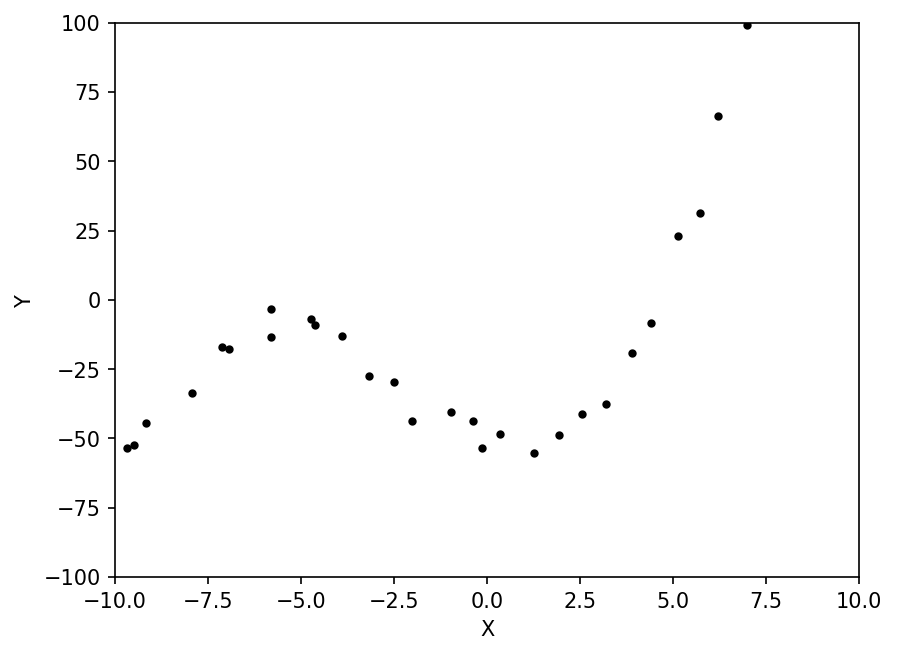

In [42]:
def generate_data (sample_size = 40):
    
    #true_degee = 4; true_theta = [0, -2.5, -1.9, -0.019, 0.021]
    true_degee = 3; true_theta = [-50, -4, 1.9, 0.25]

    
    #X = np.random.rand(sample_size) * 20 - 10
    X = np.linspace(-10, 10, sample_size) + np.random.randn(sample_size)*0.25
    
    poly = PolynomialFeatures(true_degee)
    X_poly = poly.fit_transform(X.reshape(-1, 1))
    print('X shape: ', X.shape)
    print('X_poly shape: ', X_poly.shape)

    display(pd.DataFrame (X).head())
    display(pd.DataFrame (X_poly).head())

    Y = np.dot(X_poly, true_theta) + np.random.randn(sample_size) * 5 #+ np.random.randn(sample_size) * np.sqrt (np.abs(X)) * 2
    return X, Y

X, Y = generate_data (33)

plt.figure()
plt.plot(X, Y, '.k')
plt.xlabel('X')
plt.ylabel('Y')
plt.ylim([-100, 100])
plt.xlim([-10, 10])


## Создаем новый класс моделей машинного обучения - полиномиальную регрессию

Данная модель объединяет модель линейной регресии [LinearRegression](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LinearRegression.html), модель порождения полиномиальных признаков   [PolynomialFeatures](https://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) и, опционально, произвольную модель масштабирования данных.  

Модель имеет два **гиперпараметра**:
- Степень полинома
- Модель масштабирования данных (по умолчанию отсутствует)

In [5]:
class PolynomialRegression:
    def __init__(self, degree = 1, scaler = None):
        self.degree = degree
        self.regressor = LinearRegression()
        self.scaler = scaler () if scaler is not None else None
        
    def fit(self, X, Y):
        self.poly = PolynomialFeatures(self.degree)
        X_poly = self.poly.fit_transform(X.reshape(-1, 1))
        
        if self.scaler is not None:
            X_poly = self.scaler.fit_transform(X_poly)
        #display(pd.DataFrame(X_poly).describe())
        self.regressor.fit(X_poly, Y)
        
    def predict(self, X):
        X_poly = self.poly.fit_transform(X.reshape(-1, 1))
        if self.scaler is not None:
            X_poly = self.scaler.transform(X_poly)       
        return self.regressor.predict(X_poly)

## Обучение модели с вручную задаваемыми гиперпараметрами 

Изучаем, как ведет себя модель с различными гиперпараметрами (меняем степень полинома и модель масштабирования данных) и при различном размере набора данных.

RMSE =  0.1308447901622455


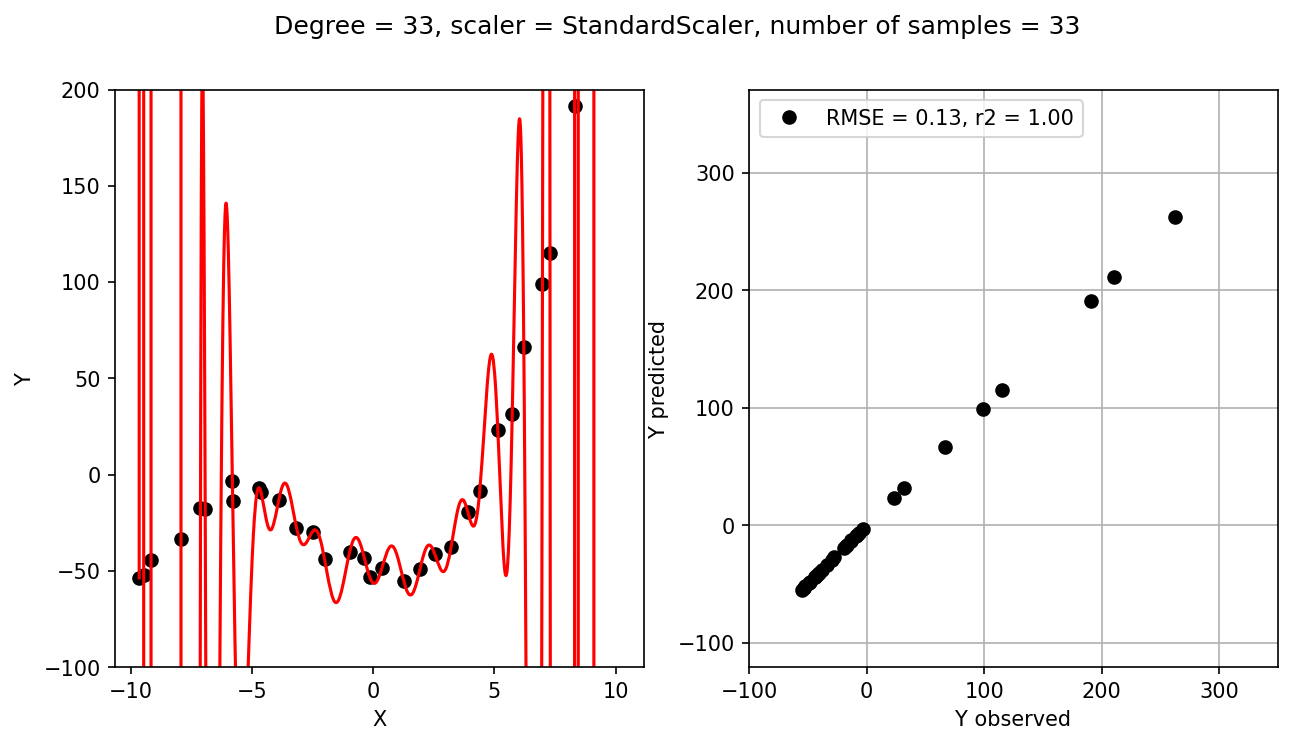

In [45]:
def evaluate_model (model, X, Y):
    model.fit(X, Y)
    Y_predicted = model.predict(X)
    rmse = np.sqrt(mean_squared_error(Y, Y_predicted))
    r2 = r2_score(Y, Y_predicted)
    
    print ('RMSE = ', rmse)
    X_smooth = np.linspace(X.min(), X.max(), 10000)
    Y_predicted_smooth = model.predict(X_smooth)

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,2)
    plt.plot (Y, Y_predicted, 'ok', label = 'RMSE = %.2f, r2 = %.2f'%(rmse, r2))
    plt.axis('equal')
    plt.grid()
    plt.ylim([-100, 350])
    plt.xlim([-100, 350])
    plt.xlabel('Y observed')
    plt.ylabel('Y predicted')
    plt.legend(loc='upper left')

    plt.subplot(1,2,1)
    plt.plot(X, Y, 'ok')
    plt.ylim([-100, 200])
    plt.plot(X_smooth, Y_predicted_smooth, '-r')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.suptitle('Degree = %d, scaler = %s, number of samples = %d'%(model.degree, model.scaler.__class__.__name__, Y.shape[0]))

#model = PolynomialRegression(30) 
model = PolynomialRegression(33, scaler=StandardScaler) 

evaluate_model (model, X, Y)


## Оптимизация ~~гиперпараметров~~ гиперпараметра методом конечного перебора

Подойдем к проблеме оптимизации гиперпараметра (степени полинома) формально и попробуем найти оптимальное значение. 

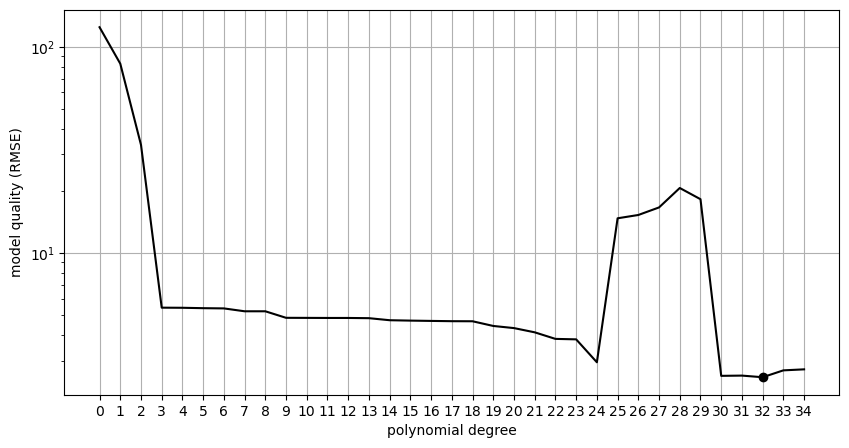

In [6]:
model_quality = []

degrees = range(0, 35)
for degree in degrees:
    model = PolynomialRegression(degree, scaler = StandardScaler)
    model.fit(X, Y)
    Y_predicted = model.predict(X)
    model_quality.append (np.sqrt(mean_squared_error(Y, Y_predicted)))

best_idx  = np.argmin(model_quality)

plt.figure(figsize=(10,5))
plt.plot (degrees, model_quality, '-k')
plt.plot (degrees[best_idx], model_quality[best_idx], 'ok')
plt.grid()
plt.xlabel('polynomial degree')
plt.ylabel('model quality (RMSE)')

plt.yscale('log')
_ = plt.xticks(degrees)

## Оптимизация ~~гиперпараметров~~ гиперпараметра методом конечного перебора - **теперь с разделением на тренировочную и тестовую выборки**

C:\Users\mvar9\AppData\Local\Temp\ipykernel_9796\2868953682.py:78: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  p23.set_data(degrees[best_idx_train], rmse_train[best_idx_train])
C:\Users\mvar9\AppData\Local\Temp\ipykernel_9796\2868953682.py:79: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  p24.set_data(degrees[best_idx_test], rmse_test[best_idx_test])
MovieWriter ffmpeg unavailable; using Pillow instead.
C:\Users\mvar9\AppData\Local\Temp\ipykernel_9796\2868953682.py:78: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  p23.set_data(degrees[best_idx_train], rmse_train[best_idx_train])
C:\Users\mvar9\AppData\Local\Temp\ipykernel_9796\2868953682.py:79: MatplotlibDeprecationWarning: Setting data with a non sequence type i

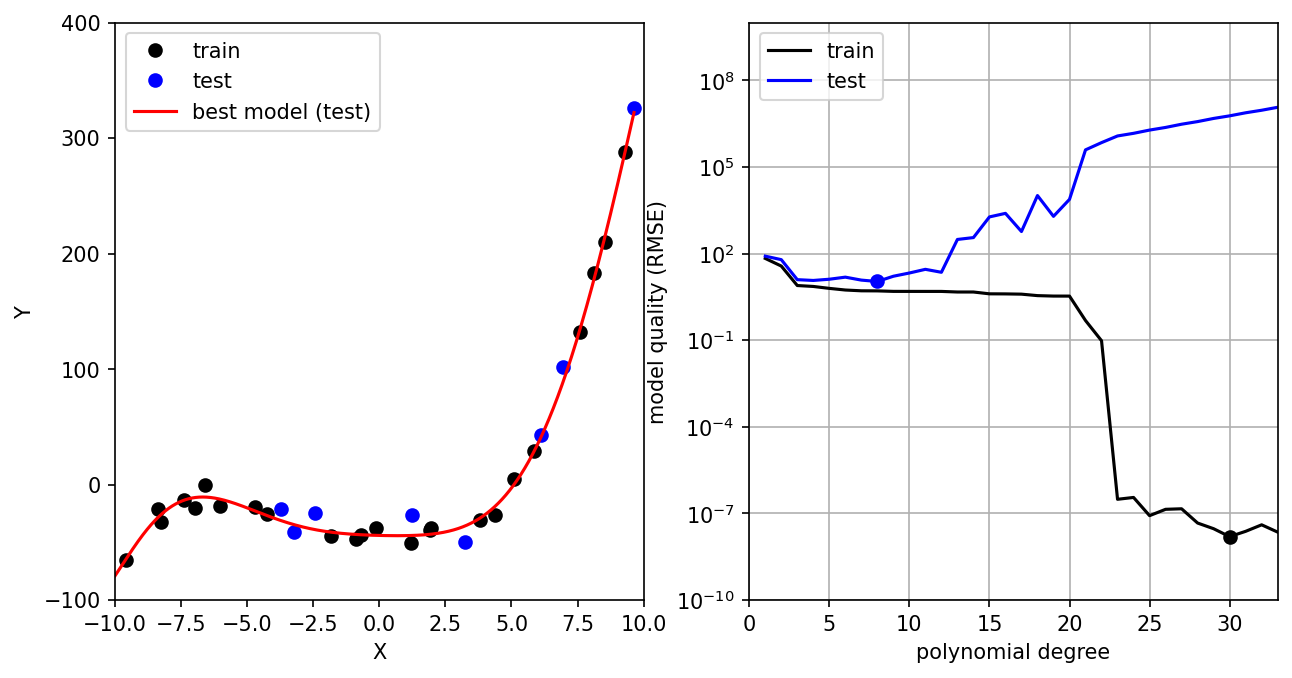

In [29]:
import matplotlib.animation as animation

plt.rcParams['savefig.dpi'] = 150
plt.rcParams['figure.dpi'] = 150

degrees = range(1, Y.shape[0]+1)


fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
# p11, = plt.plot(x_train, y_train, 'ok', label = 'train')
# p12, = plt.plot(x_test, y_test, 'ob', label = 'test')
# p13, = plt.plot(X_smooth, Y_predicted_smooth, '-r', label = 'best model (test)')
p11, = plt.plot(0, 0, 'ok', label = 'train')
p12, = plt.plot(0, 0, 'ob', label = 'test')
p13, = plt.plot(0, 0, '-r', label = 'best model (test)')

plt.xlabel('X')
plt.ylabel('Y')
plt.xlim([-10, 10])
plt.ylim([-100, 400])
plt.legend()

plt.subplot(1,2,2)
# p21, = plt.plot (degrees, rmse_train, '-k', label = 'train')
# p22, = plt.plot (degrees, rmse_test, '-b', label = 'test')
# p23, = plt.plot (degrees[best_idx_train], rmse_train[best_idx_train], 'ok')
# p24, = plt.plot (degrees[best_idx_test], rmse_test[best_idx_test], 'ob')
p21, = plt.plot (1, 1, '-k', label = 'train')
p22, = plt.plot (1, 1, '-b', label = 'test')
p23, = plt.plot (1, 1, 'ok')
p24, = plt.plot (1, 1, 'ob')
plt.xlim([0, degrees[-1]])


plt.grid()
plt.legend(loc='upper left')
plt.xlabel('polynomial degree')
plt.ylabel('model quality (RMSE)')

plt.yscale('log')
plt.ylim([10**-10, 10**10])


def optimize_hyperparameter (i):

    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

    models = []
    rmse_test = []
    rmse_train = []


    for degree in degrees:
        model = PolynomialRegression(degree, scaler = StandardScaler)
        
        model.fit(x_train, y_train)
        y_test_predicted = model.predict(x_test)
        y_train_predicted = model.predict(x_train)
        
        rmse_test.append (np.sqrt(mean_squared_error(y_test, y_test_predicted)))
        rmse_train.append (np.sqrt(mean_squared_error(y_train, y_train_predicted)))
        models.append(model)

    best_idx_test  = np.argmin(rmse_test)
    best_idx_train = np.argmin(rmse_train)

    model = models[best_idx_test]
    X_smooth = np.linspace(X.min(), X.max(), 10000)
    Y_predicted_smooth = model.predict(X_smooth)

    p11.set_data(x_train, y_train)
    p12.set_data(x_test, y_test)
    p13.set_data(X_smooth, Y_predicted_smooth)

    p21.set_data(degrees, rmse_train)
    p22.set_data(degrees, rmse_test)
    p23.set_data(degrees[best_idx_train], rmse_train[best_idx_train])
    p24.set_data(degrees[best_idx_test], rmse_test[best_idx_test])

    return p11, p12, p13, p21, p22, p23, p24


optimize_hyperparameter(0)    

ani = animation.FuncAnimation(
    fig,
    optimize_hyperparameter,
    interval=500,
    blit=False,  # blitting can't be used with Figure artists
    frames=range(0,10),
    repeat_delay=100,
)

ani.save('animation.gif') 
